In [10]:
# %pip install openpyxl
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from sklearn.metrics import r2_score 
from scipy.optimize import differential_evolution, minimize

In [11]:
df = pd.read_csv("../dados/bat_data.csv",header=0)
df2 = pd.read_csv("../dados/bat_data2.csv",header=0)
df

,apa_t,apa_mm,amox_t,amox_mm,ester_t,ester_mm,aoh_t,aoh_mm
0,0.0,60.00000,0.0,0.000000,0.0,20.000000,0.0,0.000000
1,30.0,59.81431,30.0,0.155106,30.0,18.986957,30.0,0.822901
2,60.0,59.73249,60.0,0.215833,60.0,18.747155,60.0,0.973603
3,90.0,59.80909,90.0,0.282864,90.0,18.369786,90.0,1.184325
4,120.0,59.65543,120.0,0.458630,120.0,17.961840,120.0,1.272074
5,187.5,59.59763,187.5,0.603443,187.5,17.285627,187.5,1.636247
6,240.0,59.38548,240.0,0.725315,240.0,16.719786,240.0,1.888615
7,300.0,59.28374,300.0,0.911769,300.0,16.075576,300.0,2.266852
8,360.0,58.99810,360.0,1.188997,360.0,15.035050,360.0,2.752346
9,420.0,58.73914,420.0,1.387558,420.0,14.085256,420.0,3.340910


In [12]:
CAB_medida1  = df.loc[:,'ester_mm'].dropna().to_numpy(dtype=float)
CAN_medida1 = df.loc[:,'amox_mm'].dropna().to_numpy(dtype=float)
CNH_medida1 = df.loc[:,'apa_mm'].dropna().to_numpy(dtype=float)
CAOH_medida1 = df.loc[:,'aoh_mm'].dropna().to_numpy(dtype=float)
t1 = df.loc[:,'ester_t'].dropna().to_numpy(dtype=float)

experimental_data1 = np.array((CAB_medida1, CAN_medida1, CNH_medida1, CAOH_medida1))
tempo_substratos1 = t1
tempo_produtos1 = t1
experimental_data1.shape

(4, 11)

In [13]:
CAB_medida2  = df2.loc[:,'ester_mm'].dropna().to_numpy(dtype=float)
CAN_medida2 = df2.loc[:,'amox_mm'].dropna().to_numpy(dtype=float)
CNH_medida2 = df2.loc[:,'apa_mm'].dropna().to_numpy(dtype=float)
CAOH_medida2 = df2.loc[:,'aoh_mm'].dropna().to_numpy(dtype=float)
t2 = df2.loc[:,'ester_t'].dropna().to_numpy(dtype=float)

experimental_data2 = np.array((CAB_medida2, CAN_medida2, CNH_medida2, CAOH_medida2))
tempo_substratos2 = t2
tempo_produtos2 = t2

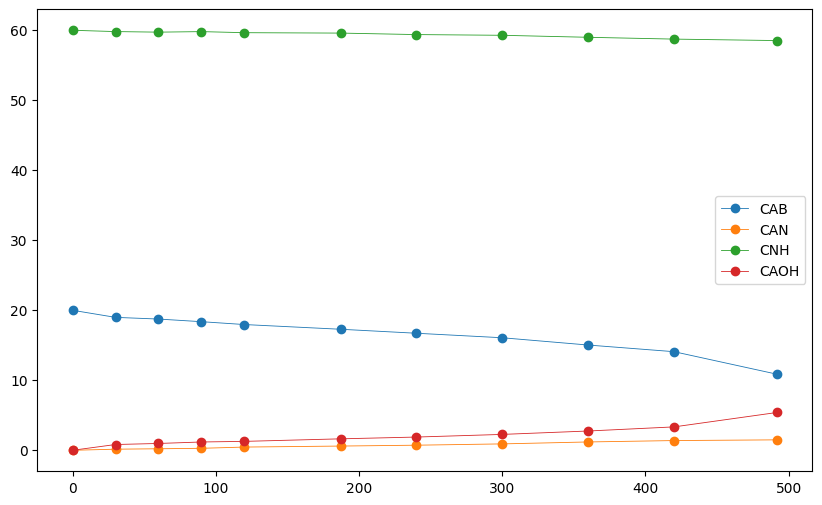

In [14]:
fig = plt.figure(figsize=(10,6))
plt.plot(t1,CAB_medida1,'-o',linewidth=0.6)
plt.plot(t1,CAN_medida1,'-o',linewidth=0.6)
plt.plot(t1,CNH_medida1,'-o',linewidth=0.6)
plt.plot(t1,CAOH_medida1,'-o',linewidth=0.6)
plt.legend(['CAB','CAN','CNH','CAOH'])

In [15]:
Cez = 1

kcat1        = 0.181
kcat2        = 0.395
Km1          = 5.449
Km2          = 1.694
Tmax         = 0.824
Ken          = 7.947
kAB          = 0.682
kAN          = 1.989
kAOH         = 9.856
kNH          = 9.763

P = np.zeros(10)
P[0]   = kcat1    
P[1]   = kcat2    
P[2]   = Km1      
P[3]   = Km2      
P[4]   = Tmax     
P[5]   = Ken      
P[6]   = kAB      
P[7]   = kAN      
P[8]   = kAOH     
P[9]  = kNH 

Np = len(P)

In [16]:
CI1 = np.array([CAB_medida1[0],CAN_medida1[0],CNH_medida1[0],CAOH_medida1[0]])
CI2 = np.array([CAB_medida2[0],CAN_medida2[0],CNH_medida2[0],CAOH_medida2[0]])

In [17]:
def enzymic_amox(t,y, 
kcat1,
kcat2,
Km1,
Km2,  
Tmax, 
Ken,  
kAB,  
kAN,  
kAOH, 
kNH):
    FAB = 0
    FNH = 0 
    
    CAB = y[0]
    CAN = y[1]
    CNH = y[2]
    CAOH = y[3]

    # Consumo de ester
    VAB = (kcat1*CAB*Cez)/((Km1*(1 + (CAN/kAN) + (CAOH/kAOH))) + CAB)
    
    # Hidrolise de amoxicilina
    VAN = (kcat2*CAN*Cez)/((Km2*(1 + (CAB/kAB) + (CNH/kNH) + (CAOH/kAOH))) + CAN)
    
    # Enzima saturada com 6-apa
    X   = CNH/(Ken + CNH)
    
    # Sintese enzimatica
    VS  = VAB*Tmax*X

    # Hidrolise de ester
    Vh1 = (VAB - VS) 

    dy = np.zeros(4)

    # C. ester
    dy[0] = ((-(VS - VAN) - (Vh1 + VAN)) + FAB) 
    
    # C. amox
    dy[1] = (VS - VAN)                         
    
    # C. 6-apa
    dy[2] = (-(VS - VAN) + FNH)                
    
    # C. POHPG
    dy[3] =  (Vh1 + VAN)
    
    return np.array(dy)                                           

In [18]:
def ode15s_amox(P, CI, t):
    return scipy.integrate.solve_ivp(enzymic_amox,t_span=(t[0],t[-1]),t_eval=t,y0=CI,method='BDF',args=P)

In [19]:
def calculate_error(model_output, experimental_data):
    total_error = np.sum((model_output - experimental_data) ** 2)
    print(total_error,end="\r")
    return total_error

In [20]:
def objective_function(params):
    record.append(params)
    sol1 = ode15s_amox(params,CI1,t1).y
    sol2 = ode15s_amox(params,CI2,t2).y
    model_output1 = sol1
    model_output2 = sol2
    return calculate_error(model_output1,experimental_data1) + calculate_error(model_output2,experimental_data2)


In [21]:
def objective_function_test(params):
    record.append(params)
    sol1 = ode15s_amox(params,CI1,t1).y
    model_output1 = sol1
    return calculate_error(model_output1,experimental_data1)

In [23]:
method = 'Nelder-Mead'
options = {'maxiter':1000}
record = []
bounds = [(0.001, 20) for _ in range(len(P))]

result = minimize(objective_function, P, method=method,bounds=bounds,options=options)
record = np.array(record)
# Optimized parameters
optimized_parameters = result.x
print("Optimized Parameters:", optimized_parameters)
P_new = optimized_parameters

Optimized Parameters: [2.13832267e-01 2.44785961e-01 1.27588341e+01 2.52220056e-03
 8.70621189e-01 1.53316572e+01 1.42363301e-03 3.11029757e+00
 9.77530029e+00 2.13208292e-03]


k2 0.21383226746140832
k3 0.24478596138648903
k4 12.758834137085252
k5 0.002522200563730979
KS 0.8706211886195323
KP 15.331657198030108
KN 0.0014236330111862742
kmenos4 3.1102975739248437


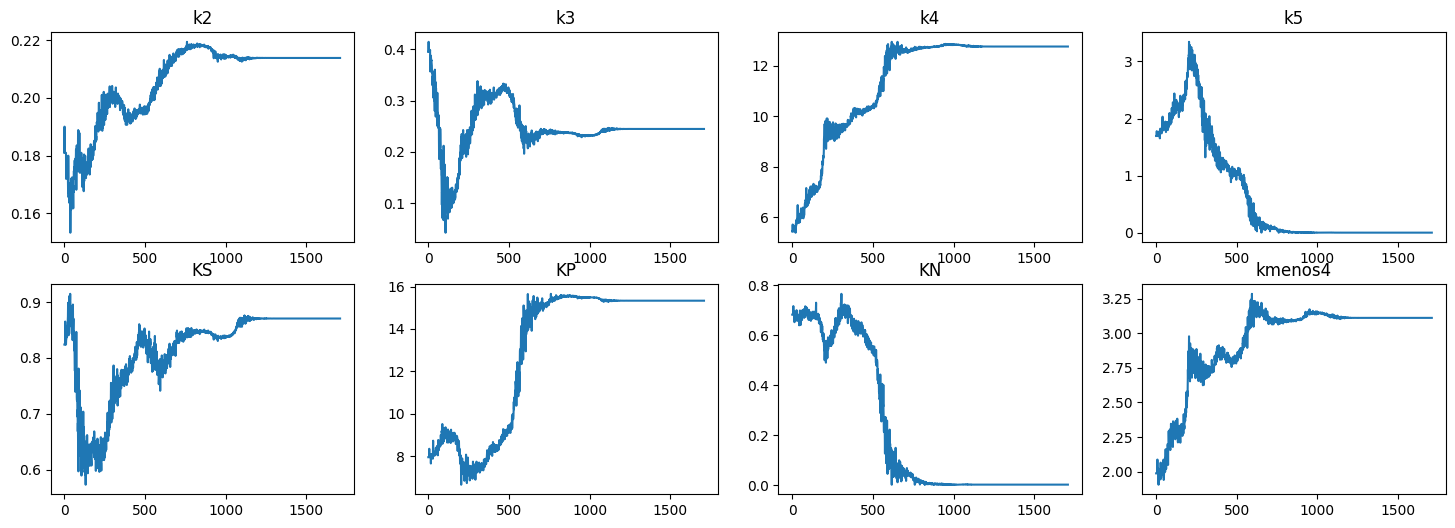

In [26]:
fig,ax = plt.subplots(2,4,figsize=[18,6])
ax = ax.flatten()
labels = ['k2',
'k3',
'k4',
'k5',
'KS',
'KP',
'KN',
'kmenos4']
N = record.shape[0]
method = method.replace('-','')
for idx,g in enumerate(ax):
    g.plot(record[:,idx])
    g.set_title(labels[idx])
    print(labels[idx],P_new[idx])
fig.savefig(f"../results/{method}_bat_model_1/{method}_evo.png",dpi=500)

In [27]:
sol1 = ode15s_amox(P_new,CI1,t1).y
CAB1  = sol1[0]
CAN1  = sol1[1] 
CNH1 = sol1[2]
CAOH1 = sol1[3]

sol2 = ode15s_amox(P_new,CI2,t2).y
CAB2  = sol2[0]
CAN2  = sol2[1] 
CNH2 = sol2[2]
CAOH2 = sol2[3]

In [28]:
results_dir = f"../results/{method}_bat_model_1"

names = ['Ester','6-APA','AMOX','POHPG']
medidas = [
    [CAB_medida1,CAB1],
    [CNH_medida1,CNH1],
    [CAN_medida1,CAN1],
    [CAOH_medida1,CAOH1]
]
for name, medida in zip(names, medidas):
    plt.plot(t1, medida[0], 'ob', label='Medida')
    plt.plot(t1, medida[1], '-ok', label='Estimada')
    plt.xlabel('Tempo (h)')
    plt.ylabel(f"Concentração de {name} (g/L)")
    plt.legend() # Adjust legend position
    plt.title(f"Concentração de {name} ao Longo do Tempo R={r2_score(medida[0],medida[1])}")
    plt.savefig(f"{results_dir}/{name}_estimate.png", dpi=400)
    plt.close()  # Close the figure to release memory


In [29]:
results_dir = f"../results/{method}_bat_model_1"

names = ['Ester','6-APA','AMOX','POHPG']
medidas = [
    [CAB_medida2,CAB2],
    [CNH_medida2,CNH2],
    [CAN_medida2,CAN2],
    [CAOH_medida2,CAOH2]
]
for name, medida in zip(names, medidas):
    plt.plot(t2, medida[0], 'ob', label='Medida')
    plt.plot(t2, medida[1], '-ok', label='Estimada')
    plt.xlabel('Tempo (h)')
    plt.ylabel(f"Concentração de {name} (g/L)")
    plt.legend() # Adjust legend position
    plt.title(f"Concentração de {name} ao Longo do Tempo R={r2_score(medida[0],medida[1])}")
    plt.savefig(f"{results_dir}/{name}_estimate2.png", dpi=400)
    plt.close()  # Close the figure to release memory

Text(0, 0.5, 'mM')

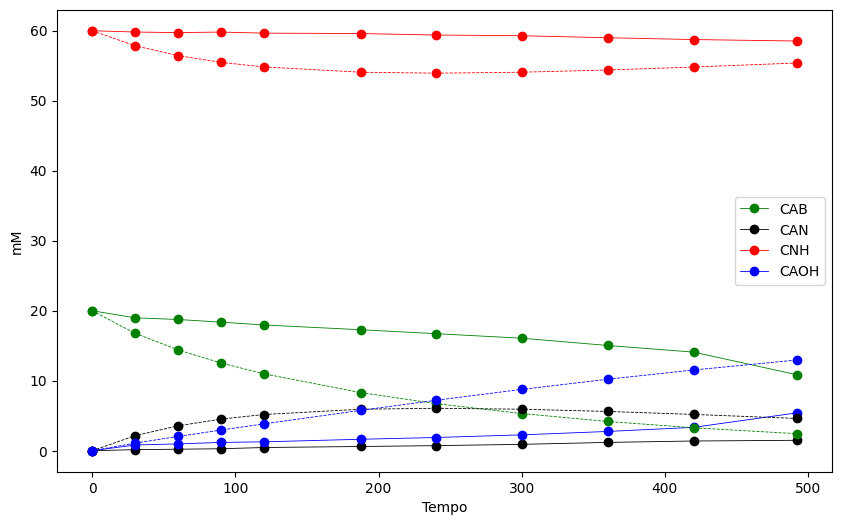

In [30]:
fig = plt.figure(figsize=(10,6))
plt.plot(t1,CAB_medida1,'-og',linewidth=0.6)
plt.plot(t1,CAN_medida1,'-ok',linewidth=0.6)
plt.plot(t1,CNH_medida1,'-or',linewidth=0.6)
plt.plot(t1,CAOH_medida1,'-ob',linewidth=0.6)
plt.legend(['CAB','CAN','CNH','CAOH'])
plt.plot(t1, CAB1,'--og',linewidth=0.6)
plt.plot(t1, CAN1,'--ok',linewidth=0.6)
plt.plot(t1, CNH1,'--or',linewidth=0.6)
plt.plot(t1, CAOH1,'--ob',linewidth=0.6)
plt.xlabel('Tempo')
plt.ylabel('mM')

Text(0, 0.5, 'mM')

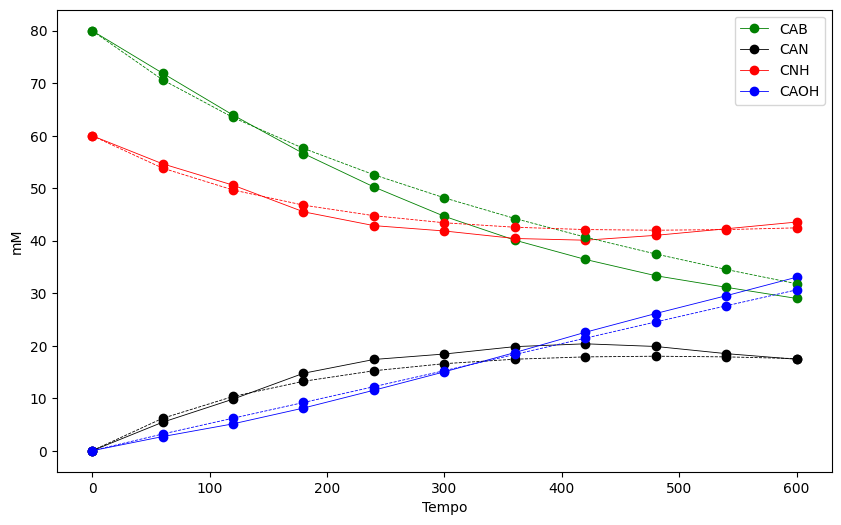

In [31]:
fig = plt.figure(figsize=(10,6))
plt.plot(t2,CAB_medida2,'-og',linewidth=0.6)
plt.plot(t2,CAN_medida2,'-ok',linewidth=0.6)
plt.plot(t2,CNH_medida2,'-or',linewidth=0.6)
plt.plot(t2,CAOH_medida2,'-ob',linewidth=0.6)
plt.legend(['CAB','CAN','CNH','CAOH'])
plt.plot(t2, CAB2,'--og',linewidth=0.6)
plt.plot(t2, CAN2,'--ok',linewidth=0.6)
plt.plot(t2, CNH2,'--or',linewidth=0.6)
plt.plot(t2, CAOH2,'--ob',linewidth=0.6)
plt.xlabel('Tempo')
plt.ylabel('mM')